# 1 Izbira metode in optimizacija hiperparametrov

In [2]:
import pandas as pd
import numpy as np

PODATKI = 'podatki.csv'
RANDOM_SEED = 420

In [3]:
data = pd.read_csv(PODATKI)
print('Število primerov: ', len(data))
features = data.columns[:-1]
print('Število značilk: ', len(features))
data['y'].value_counts()

Število primerov:  1203
Število značilk:  30


teamEdward    1025
teamJacob      178
Name: y, dtype: int64

Originalni podatki, iz katerih je pridobljen dataset `data`, vsebujejo največ 130 značilk in 2203 primerov. Očitno gre za binarno klasifikacijo.

In [4]:
# za lažje delo spremenim y 
data['y'] = data['y'].map(lambda x : True if x == 'teamEdward' else False)
data['y'].value_counts()

True     1025
False     178
Name: y, dtype: int64

## 1.1 Ročno

Najprej bom izrisal porazdelitve posameznih razredov

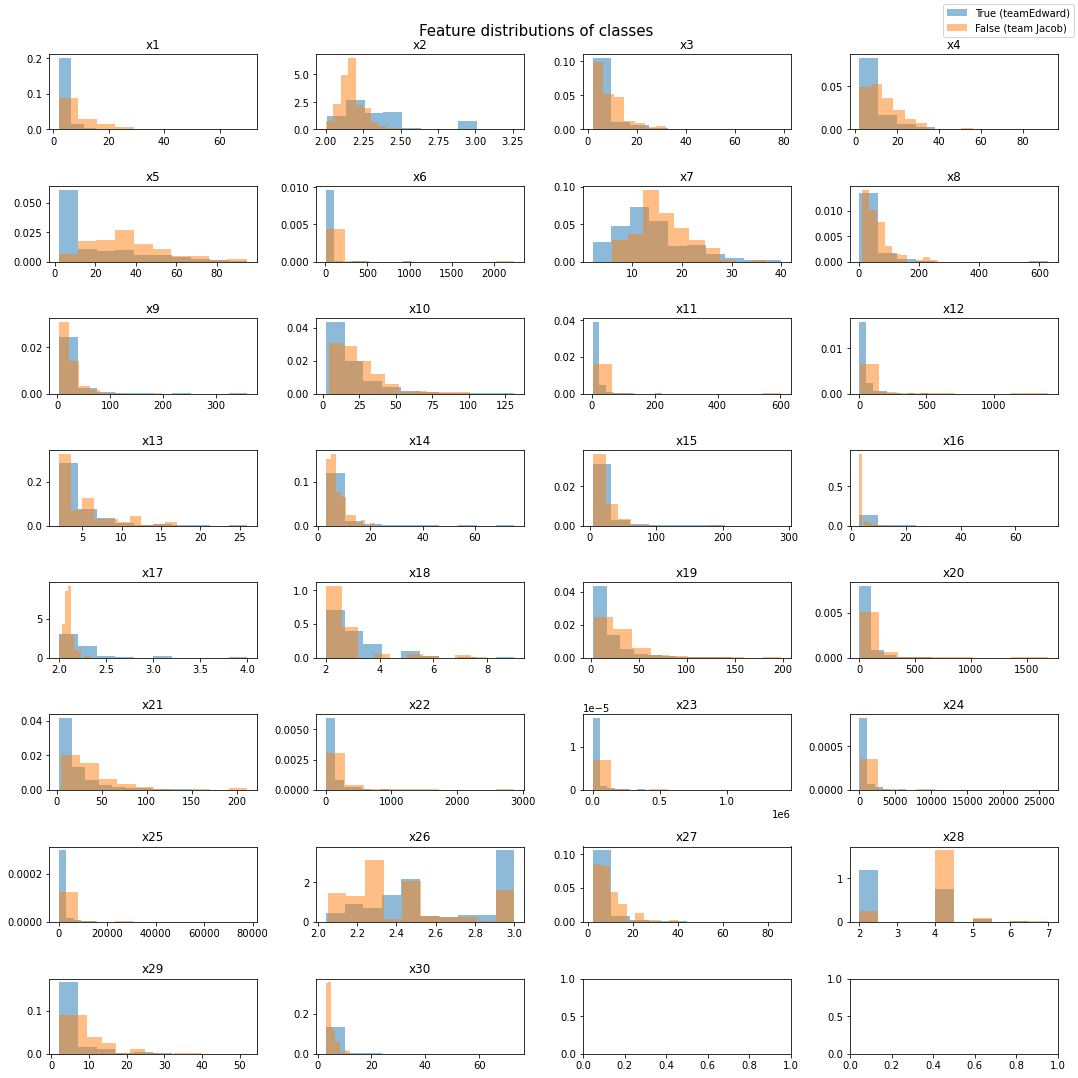

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(15, 15))
fig.suptitle("Feature distributions of classes", fontsize=15)

for index, feature in enumerate(features):
    # True
    data[data["y"]][feature].plot.hist(
        ax=ax[index // 4, index % 4], label="True (teamEdward)", alpha=0.5, density=True
    )
    # y = False
    data[~data["y"] ][feature].plot.hist(
        ax=ax[index // 4, index % 4], label="False (team Jacob)", alpha=0.5, density=True
    )
    ax[index // 4, index % 4].set_title(feature)
    ax[index // 4, index % 4].set_ylabel("")
handles, labels = ax[index // 4, index % 4].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()


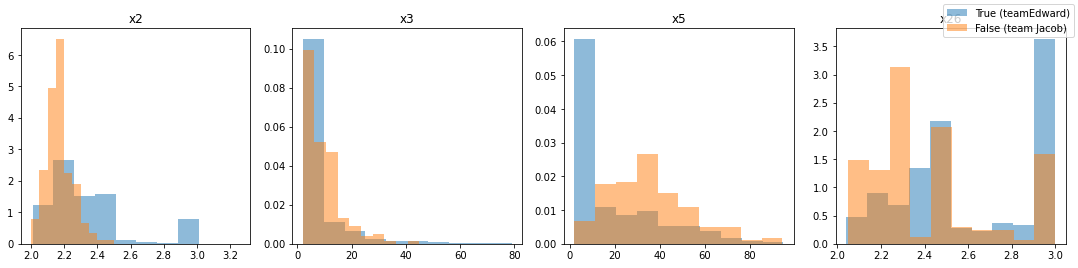

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15/4))
#fig.suptitle("Feature distributions of classes", fontsize=15)

for index, feature in enumerate(['x2', 'x3','x5' ,'x26']):
    # True
    data[data["y"]][feature].plot.hist(
        ax=ax[index % 4], label="True (teamEdward)", alpha=0.5, density=True
    )
    # y = False
    data[~data["y"] ][feature].plot.hist(
        ax=ax[index % 4], label="False (team Jacob)", alpha=0.5, density=True
    )
    ax[ index % 4].set_title(feature)
    ax[ index % 4].set_ylabel("")
handles, labels = ax[ index % 4].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='x7', ylabel='x26'>

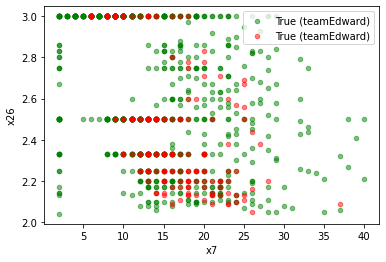

In [6]:
fig, ax = plt.subplots()
data[data["y"]].plot.scatter(x='x7', y='x26', label="True (teamEdward)", ax=ax, color = 'green',alpha=0.5)
data[~data["y"]].plot.scatter(x='x7', y='x26', label="True (teamEdward)",ax=ax, color='red',alpha=0.5)

In [7]:
import matplotlib.pyplot as plt

feature_pairs = [(features[i], features[j])  for i in range(len(features)) for j in range(i+1, len(features))]
# fig, ax = plt.subplots(nrows=1+len(feature_pairs) // 4, ncols=4, figsize=(30*30, 15))
# fig.suptitle("Feature distributions of classes", fontsize=15)

print(feature_pairs)
for index, (f1, f2) in enumerate(feature_pairs):
    # remove the following line:
    break
    # True
    fig, ax = plt.subplots()
    data[data["y"]].plot.scatter(x=f1, y=f2, label="True (teamEdward)", ax=ax, color='green',alpha=0.5)
    data[~data["y"]].plot.scatter(x=f1, y=f2, label="False (teamJacob)", ax=ax, color='red',alpha=0.5)
    plt.savefig(f'img/scatter_{f1}_{f2}.png')
    #plt.show()
plt.show()


[('x1', 'x2'), ('x1', 'x3'), ('x1', 'x4'), ('x1', 'x5'), ('x1', 'x6'), ('x1', 'x7'), ('x1', 'x8'), ('x1', 'x9'), ('x1', 'x10'), ('x1', 'x11'), ('x1', 'x12'), ('x1', 'x13'), ('x1', 'x14'), ('x1', 'x15'), ('x1', 'x16'), ('x1', 'x17'), ('x1', 'x18'), ('x1', 'x19'), ('x1', 'x20'), ('x1', 'x21'), ('x1', 'x22'), ('x1', 'x23'), ('x1', 'x24'), ('x1', 'x25'), ('x1', 'x26'), ('x1', 'x27'), ('x1', 'x28'), ('x1', 'x29'), ('x1', 'x30'), ('x2', 'x3'), ('x2', 'x4'), ('x2', 'x5'), ('x2', 'x6'), ('x2', 'x7'), ('x2', 'x8'), ('x2', 'x9'), ('x2', 'x10'), ('x2', 'x11'), ('x2', 'x12'), ('x2', 'x13'), ('x2', 'x14'), ('x2', 'x15'), ('x2', 'x16'), ('x2', 'x17'), ('x2', 'x18'), ('x2', 'x19'), ('x2', 'x20'), ('x2', 'x21'), ('x2', 'x22'), ('x2', 'x23'), ('x2', 'x24'), ('x2', 'x25'), ('x2', 'x26'), ('x2', 'x27'), ('x2', 'x28'), ('x2', 'x29'), ('x2', 'x30'), ('x3', 'x4'), ('x3', 'x5'), ('x3', 'x6'), ('x3', 'x7'), ('x3', 'x8'), ('x3', 'x9'), ('x3', 'x10'), ('x3', 'x11'), ('x3', 'x12'), ('x3', 'x13'), ('x3', 'x14'), 

In [6]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test =  train_test_split(data[features], data['y'], test_size=1/4, random_state=RANDOM_SEED)


# save to parquet
X_test['y'] = y_test
X_test.to_parquet('parquet/test.pq')
X_test = X_test.drop(columns = ['y'])

In [9]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

# hitra primerjava modelov 
tree = LGBMClassifier()
tree.fit(X_train, y_train)
pred_proba = tree.predict_proba(X_test)
performance = roc_auc_score(y_test, pred_proba[:,1])
print("ROC AUC tree: ", performance)

svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
performance = roc_auc_score(y_test, pred)
print("ROC AUC svc: ", performance)

ROC AUC tree:  0.9381805997654548
ROC AUC svc:  0.5


In [10]:
from ray import tune 

def tune_classifier(config):
    model = LGBMClassifier(**config)
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)


    mean_roc_auc = np.mean(cv_results)
    
    tune.report(
        mean_roc_auc=mean_roc_auc,
        done=True,
    )

In [11]:
config = {
    "objective": "binary",
    "metric": "auc",
    "verbose": -1,
    "boosting_type": "gbdt",
    "num_leaves": tune.randint(5, 100),
    "n_estimators": tune.randint(50, 100),
    "min_child_samples": tune.choice([5, 10, 15, 25, 50,  100, 200]),
    "learning_rate": tune.loguniform(1e-2, 0.05),
}
analysis = tune.run(tune_classifier, resources_per_trial={"cpu": 5}, config=config, num_samples=200, verbose=1, raise_on_failed_trial=False)
results = analysis.dataframe()
results.head()

2023-03-31 17:06:58,661	INFO tune.py:762 -- Total run time: 26.45 seconds (26.00 seconds for the tuning loop).


,mean_roc_auc,done,time_this_iter_s,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,...,warmup_time,config/boosting_type,config/learning_rate,config/metric,config/min_child_samples,config/n_estimators,config/num_leaves,config/objective,config/verbose,logdir
0,0.933768,True,0.234173,NaN,NaN,1,9f154_00000,6cfd63782c5445c783f735e0ce1af926,2023-03-31_17-06-35,1680275195,...,0.003225,gbdt,0.043267,auc,25,56,95,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
1,0.931715,True,0.485865,NaN,NaN,1,9f154_00001,0de6c61996524e8c980ff19954295b3e,2023-03-31_17-06-38,1680275198,...,0.005308,gbdt,0.019616,auc,10,81,30,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
2,0.928435,True,0.535124,NaN,NaN,1,9f154_00002,ce5c73ffe2f0486dad7fc935bfc0d605,2023-03-31_17-06-38,1680275198,...,0.004819,gbdt,0.011536,auc,10,82,70,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
3,0.926814,True,0.810083,NaN,NaN,1,9f154_00003,6cfd63782c5445c783f735e0ce1af926,2023-03-31_17-06-35,1680275195,...,0.003225,gbdt,0.038497,auc,5,66,89,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...
4,0.896127,True,0.135413,NaN,NaN,1,9f154_00004,6cfd63782c5445c783f735e0ce1af926,2023-03-31_17-06-36,1680275196,...,0.003225,gbdt,0.023039,auc,200,87,83,binary,-1,/home/uprimozic/ray_results/tune_classifier_20...


In [12]:
params = results.iloc[0]
params_dict = results.loc[params.name][[col for col in results.columns if col.startswith('config')]].to_dict()
params_dict = {k.replace('config/', ''): v for k, v in params_dict.items()}
# za shranjevanjevanje modela:
# import json
# json.dump(params_dict, open("best_params_trees.json", "w"), indent=2)

# loading:
# params_dict = json.load(open('best_params.json', 'r'))
params_dict

{'boosting_type': 'gbdt',
 'learning_rate': 0.04326699962526493,
 'metric': 'auc',
 'min_child_samples': 25,
 'n_estimators': 56,
 'num_leaves': 95,
 'objective': 'binary',
 'verbose': -1}

Ploščina pod ROC krivuljo je:  0.9324007371418999


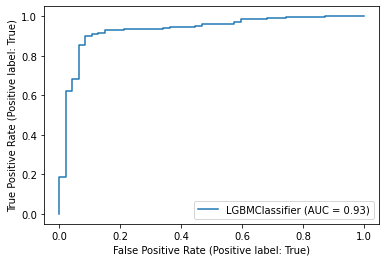

In [13]:
import matplotlib.pyplot as plt

model = LGBMClassifier(**params_dict)
model.fit(X_train, y_train)

pred_proba = model.predict_proba(X_test)
performance = roc_auc_score(y_test, pred_proba[:,1])


print('Ploščina pod ROC krivuljo je: ', performance)


RocCurveDisplay.from_estimator(model, X_test, y_test)

## 1.2 Avtomatizirano
Preizkusili bomo gradient-boosting drevesa,  najbližje sosede in svm. Uporabili bomo kombinacijo `Hyperopt` za optimizacijo in `ray.tune` za vodenje in potek procesa. 


*TODO mogoče še:random forest*

In [7]:
from hyperopt import hp
from sklearn.tree import DecisionTreeClassifier

# hack za svc 
def restack(params):
    ''' 
    Spremeni slovar za parametre za SVC, ki je oblike 
    'kernel_params' : { parametri p1 : P1, p2 : P2, ... },
     'q2: Q2 ... 

    v en slovar oblike 
    'p1' : P1
    p2 : P2, 
    ...
    q2 : Q2
    ...
    '''
    nested_dict = params.get('kernel_params')
    if nested_dict is None:
        return params
    for key, value in nested_dict.items():
        params[key] = value 
    params.pop('kernel_params')
    return params
    

# prostor možnih parametrov
param_space = {
    "algo": hp.choice('algo', [
        # lepa rešitev je, da hp za 'algo' izbere nek slovar, kjer je 
        # 'model' - (sklarn-type) model 
        # 'params' - parametri tega modela 
        # na tak način se znotraj kode za kriterijsko funckijo ognemo ločevanja na možne izbire! 
        {
            'name' : 'lgbm',
            'model' : LGBMClassifier,
            'params' : {
                "objective": "binary",
                "metric": "auc",
                "verbose": -1,
                "boosting_type": "gbdt",
                # loguniform - večje vrednosti so bolj narazen
                "num_leaves": hp.choice("num_leaves", [i**2 for i in range(3, 15)]),
                "n_estimators": hp.choice('n_estimators', [i**2 for i in range(3, 20)]),
                "min_child_samples": hp.choice('min_child_samples', [5, 10, 15, 25, 50,  100, 200, 500]),
                "learning_rate": hp.loguniform('learning_rate',1e-2, 0.05),
            }
        }, 
        {
            'name' : 'tree',
            'model' : DecisionTreeClassifier,
            'params' : {
                'max_depth': hp.choice("max_depth", [i**2 for i in range(3, 20)]), 
                "min_samples_split": hp.choice('min_samples_split', [2, 5, 10, 15, 25, 50, 75, 100]),
                "min_samples_leaf": hp.choice('min_samples_leaf', [2, 5, 10, 15, 25, 50, 75, 100]),
            }
        },
        {
            'name' : 'knn',
            'model' : KNeighborsClassifier,
            'params' : {
                'n_neighbors': hp.choice("n_neighbors", [1, 2, 3, 4, 5, 10, 15, 25]), 
                'n_jobs' : -1,
            }
        },
        {
            'name' : 'svc',
            'model' : SVC,
            'params' : {
                'C': hp.lognormal('C', 0, 1),
                'kernel_params': hp.choice('kernel_params', [
                    {
                        'kernel': 'linear'  # linearno
                    },
                    {
                        'kernel': 'rbf',  # radialno
                        'gamma': hp.lognormal('gamma', 0, 1)
                    },
                    {
                        'kernel': 'poly',  # polinomsko
                        'degree': hp.choice("degree", [1, 2])
                    }
                ]),
            }
        }

    ])
}

In [56]:
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search import ConcurrencyLimiter
from ray.tune import CLIReporter
from ray.air import RunConfig
from ray import tune

NUM_SAMPLES = 250
SVC_RESAMPLE_FACTOR=0.1 # 120 primerov

# kriterijska funckija
def criterion_function(config, return_score=False):
    '''
    Kriterijska funckija.
   
    Input
    -----
    :param config: slovar izbranih parametrov z ključi 'name', 'model' in 'params' 
    
    '''
    name = config['algo']['name']
    params = config['algo']['params']
    # svc ima parametre, ki so odvisni od 'kernel' : *. --> hardcoded
    if name == 'svc':
        params = restack(params)
    # ustvari model z željenimi parametri
    model = config['algo']['model'](**params)
    
    
    # učna množica za model: 
    X = X_train
    y = y_train
    # SVC se uči prepočasi, zato mu dam manj podatkov
    if name == 'svc':
        data = X
        data['y'] = y 
        data = data.sample(frac=SVC_RESAMPLE_FACTOR)
        X = data.drop(columns=['y'])
        y = data['y']
    # prečno preverjanje
    cv_results = cross_val_score(model, X, y, scoring='roc_auc', cv=5)


    mean_roc_auc = np.mean(cv_results)
    
    tune.report(
        mean_roc_auc=mean_roc_auc,
        done=True,
    )
    # vrne za minimizacijo!
    # return 1 - mean_roc_auc

# maximiziramo ploščino mod krivuljo
algo = HyperOptSearch(space=param_space, metric="mean_roc_auc", mode="max")
algo = ConcurrencyLimiter(algo, max_concurrent=8)

# logging, progress
reporter = CLIReporter()

tune_config = tune.TuneConfig(
    metric = 'mean_roc_auc',
    mode = 'max',
    search_alg=algo,
    num_samples=NUM_SAMPLES,
    time_budget_s=20
)

run_config =RunConfig(progress_reporter=reporter)

tuner = tune.Tuner(criterion_function, tune_config=tune_config, run_config=run_config)
results = tuner.fit()

== Status ==
Current time: 2023-04-01 00:12:06 (running for 00:00:01.31)
Memory usage on this node: 15.3/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/16 CPUs, 0/0 GPUs, 0.0/11.57 GiB heap, 0.0/5.78 GiB objects
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-04-01_00-12-05
Number of trials: 1/250 (1 RUNNING)
+-----------------------------+----------+-----------------------+----------------------+-------------+------------------------+------------------------+------------------------+
| Trial name                  | status   | loc                   | algo/model           | algo/name   |   algo/params/max_dept |   algo/params/min_samp |   algo/params/min_samp |
|                             |          |                       |                      |             |                      h |               les_leaf |              les_split |
|-----------------------------+----------+-----------------------+----------------------+-------------+---------

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_roc_auc,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
criterion_function_827ef5d0,2023-04-01_00-12-06,True,,cfd4b3403ae646cc83e419835126b4bc,sgsnb-upri,1,0.878363,192.168.0.105,1024749,0.0196655,0.0196655,0.0196655,1680300726,0,,1,827ef5d0,0.00273538
criterion_function_e00d739a,2023-04-01_00-12-06,True,,cfd4b3403ae646cc83e419835126b4bc,sgsnb-upri,1,0.84778,192.168.0.105,1024749,0.0304825,0.0304825,0.0304825,1680300726,0,,1,e00d739a,0.00273538


2023-04-01 00:12:06,569	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.tree._classes.DecisionTreeClassifier'>}
2023-04-01 00:12:06,620	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.tree._classes.DecisionTreeClassifier'>}
2023-04-01 00:12:06,620	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.tree._classes.DecisionTreeClassifier'>}
2023-04-01 00:12:06,813	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.tree._classes.DecisionTreeClassifier'>}
2023-04-01 00:12:06,813	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.tree._classes.DecisionTreeClassifier'>}
2023-04-01 00:12:06,

2023-04-01 00:12:14,849	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-04-01 00:12:14,920	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-04-01 00:12:15,135	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-04-01 00:12:16,188	WARNING util.py:244 -- The `reset` operation took 1.043 s, which may be a performance bottleneck.
2023-04-01 00:12:16,196	WARNING util.py:244 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


2023-04-01 00:12:16,371	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-04-01 00:12:16,563	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-04-01 00:12:16,651	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-04-01 00:12:16,726	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>}
2023-04-01 00:12:16,833	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-04-01 00:12:16,944	INFO tensorboardx.py:267 -- Removed th

2023-04-01 00:12:26,278	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'algo/model': <class 'lightgbm.sklearn.LGBMClassifier'>}
2023-04-01 00:12:26,285	INFO timeout.py:54 -- Reached timeout of 20 seconds. Stopping all trials.


== Status ==
Current time: 2023-04-01 00:12:26 (running for 00:00:21.21)
Memory usage on this node: 15.5/31.1 GiB 
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/11.57 GiB heap, 0.0/5.78 GiB objects
Current best trial: a59fecdb with mean_roc_auc=0.9351106360783781 and parameters={'algo': {'model': <class 'lightgbm.sklearn.LGBMClassifier'>, 'name': 'lgbm', 'params': {'boosting_type': 'gbdt', 'learning_rate': 1.0241779294195799, 'metric': 'auc', 'min_child_samples': 15, 'n_estimators': 121, 'num_leaves': 25, 'objective': 'binary', 'verbose': -1}}}
Result logdir: /home/uprimozic/ray_results/criterion_function_2023-04-01_00-12-05
Number of trials: 43/250 (43 TERMINATED)
+-----------------------------+------------+-----------------------+----------------------+-------------+-----------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+--------------------

2023-04-01 00:20:37,480	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Porazdelitev zmogljivosti:

In [55]:
# dataframe:
results_df = results.get_dataframe()
#for name in ['lgbm', 'tree', 'svc', 'knn']:
#    df = results_df[results_df['safdsdf'] == name]
results_df   

,mean_roc_auc,done,time_this_iter_s,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,...,config/algo/params/kernel_params/degree,config/algo/params/kernel_params/kernel,config/algo/params/boosting_type,config/algo/params/learning_rate,config/algo/params/metric,config/algo/params/min_child_samples,config/algo/params/n_estimators,config/algo/params/num_leaves,config/algo/params/objective,config/algo/params/verbose
0,0.605386,True,0.031500,NaN,NaN,1,c6fd0bcf,67ebfb05304542d9af5900d3daae9449,2023-03-31_23-51-46,1680299506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.521746,True,0.107573,NaN,NaN,1,18ad7578,deab89514b0641aca2e42171941ed460,2023-03-31_23-51-50,1680299510,...,1.0,poly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.923570,True,0.269298,NaN,NaN,1,0a309088,67ebfb05304542d9af5900d3daae9449,2023-03-31_23-51-47,1680299507,...,NaN,NaN,gbdt,1.027987,auc,15.0,36.0,9.0,binary,-1.0


Najboljši model je :  lgbm  s parametri  {'boosting_type': 'gbdt', 'learning_rate': 1.0279874826326978, 'metric': 'auc', 'min_child_samples': 15, 'n_estimators': 36, 'num_leaves': 9, 'objective': 'binary', 'verbose': -1}
Ploščina pod ROC krivuljo je:  0.9210923102697269


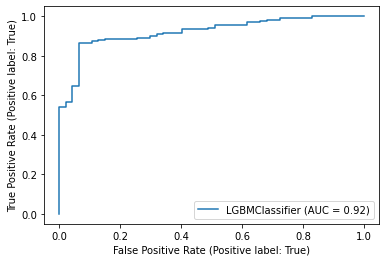

In [54]:
best_model_name = results.get_best_result().config['algo']['name']
best_params = results.get_best_result().config['algo']['params']
best_model = results.get_best_result().config['algo']['model']
if best_model_name == 'svc':
    best_params = restack(best_params)

print("Najboljši model je : ", best_model_name, " s parametri ", best_params)
# create a model with best params 
model = best_model(**best_params)
model.fit(X_train, y_train)
pred_proba = model.predict_proba(X_test)
performance = roc_auc_score(y_test, pred_proba[:,1])

print('Ploščina pod ROC krivuljo je: ', performance)
RocCurveDisplay.from_estimator(model, X_test, y_test)

Porazdelitve zmogljivosti konfiguracij:

Naključni gozdovi - model iz meta učenja

In [23]:
from sklearn.ensemble import RandomForestClassifier


# set opt params:
def tune_tune_rf(config):
    model = RandomForestClassifier(**config)
    cv_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)


    mean_roc_auc = np.mean(cv_results)
    
    tune.report(
        mean_roc_auc=mean_roc_auc,
        done=True,
    )
config = {
    "max_depth" : tune.randint(3, 100),
    "min_samples_leaf": tune.randint(5, 100),
    "ccp_alpha": tune.uniform(0,1),
    "min_samples_split": tune.choice([5, 10, 15, 25, 50,  100, 200]),
}
algo = HyperOptSearch(space=config, metric="mean_roc_auc", mode="max")
algo = ConcurrencyLimiter(algo, max_concurrent=8)



tune_config = tune.TuneConfig(
    metric = 'mean_roc_auc',
    mode = 'max',
    search_alg=algo,
    num_samples=200,
)

run_config =RunConfig(progress_reporter=reporter)

tuner = tune.Tuner(tune_tune_rf, tune_config=tune_config)
results = tuner.fit()

2023-03-31 23:07:14,275	WARNING hyperopt_search.py:192 -- You passed a `space` parameter to <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> that contained unresolved search space definitions. <class 'ray.tune.search.hyperopt.hyperopt_search.HyperOptSearch'> should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,mean_roc_auc,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
tune_tune_rf_3768a8c2,2023-03-31_23-07-24,True,,de7657e4b0124735ba06b84ccacf31d0,sgsnb-upri,1,0.5,192.168.0.105,1014115,2.84173,2.84173,2.84173,1680296844,0,,1,3768a8c2,0.0117154
tune_tune_rf_79a2453b,2023-03-31_23-07-18,True,,cde06121dba74caab37989a8c8534616,sgsnb-upri,1,0.5,192.168.0.105,1014037,2.65125,2.65125,2.65125,1680296838,0,,1,79a2453b,0.0026567


2023-03-31 23:09:42,058	INFO tune.py:762 -- Total run time: 147.77 seconds (147.45 seconds for the tuning loop).


Ploščina pod ROC krivuljo je:  0.9349137208912716


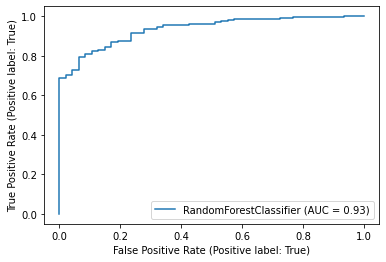

In [46]:
best_params = results.get_best_result().config
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

pred_proba = model.predict_proba(X_test)
performance = roc_auc_score(y_test, pred_proba[:,1])


print('Ploščina pod ROC krivuljo je: ', performance)


RocCurveDisplay.from_estimator(model, X_test, y_test)


Roc krivulje vseh treh modelov:

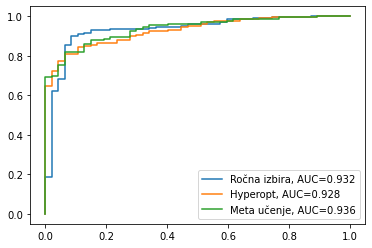

In [52]:
from sklearn.metrics import roc_curve
plt.figure(0).clf()


rocni = LGBMClassifier(**{'boosting_type': 'gbdt',
 'learning_rate': 0.04326699962526493,
 'metric': 'auc',
 'min_child_samples': 25,
 'n_estimators': 56,
 'num_leaves': 95,
 'objective': 'binary',
 'verbose': -1})

avtomatiziran = LGBMClassifier(**{'boosting_type': 'gbdt', 'learning_rate': 1.045806987710898, 'metric': 'auc', 'min_child_samples': 50, 'n_estimators': 324, 'num_leaves': 49, 'objective': 'binary', 'verbose': -1})


for m, l in [(rocni, 'Ročna izbira'), (avtomatiziran, 'Hyperopt'), (model, "Meta učenje")]:
    m.fit(X_train, y_train)
    pred_proba = m.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_proba[:,1])
    auc = roc_auc_score(y_test, pred_proba[:,1])
    plt.plot(fpr,tpr,label=l + ', AUC='+str(np.round(auc, decimals=3)))


plt.legend(loc=0)

Porazdelitev zmogljivosti -grid search

/home/uprimozic/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 245.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/uprimozic/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/uprimozic/.local/lib/python3.10/site-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/home/uprimozic/.local/lib/python3.10/site-packages/sklearn/base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "/home/uprim

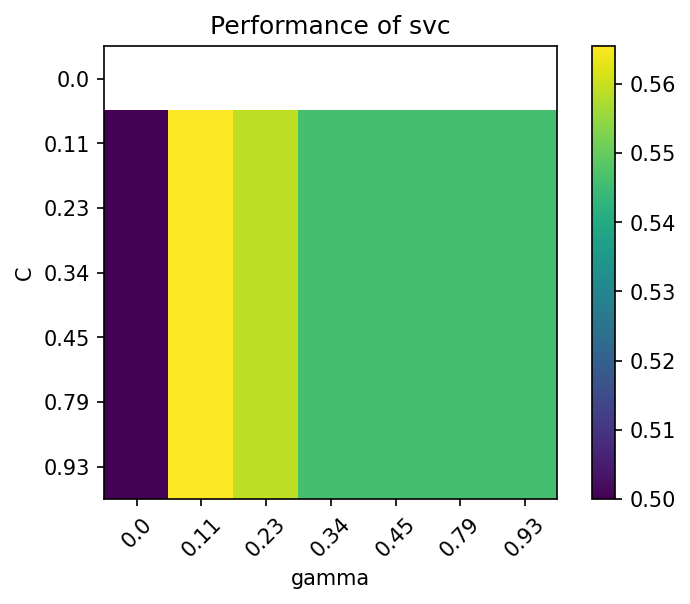

In [21]:
from sklearn.model_selection import GridSearchCV

model_dict={
'tree' : DecisionTreeClassifier,
'svc' : SVC,
'lgbm' : LGBMClassifier,
'knn' : KNeighborsClassifier
}


hiperparametri ={
  'tree': {"max_depth": [i**2 for i in range(3, 20)],
                  "min_samples_split": [2, 5, 10, 15, 25, 50, 75, 100]},
                  'lgbm' : {
                     "num_leaves":  [i**2 for i in range(3, 15)],
                "n_estimators":  [i**2 for i in range(3, 20)]

                  },
             #  'knn' : {'n_neighbors' : [2,3,4,5,10,15,20],
             #  'p' : [1,2,4,10]
             #  }
         #         'svc' : {
         #               'C' :[0.        , 0.11, 0.23, 0.34, 0.45, 0.79,  0.93 ],
         #               'kernel' : ['rbf'],
         #               'gamma' : [0.        , 0.11, 0.23, 0.34, 0.45, 0.79,  0.93 ]
#
         #         }
                
}
for name, params in hiperparametri.items():
      # učna množica za model: 
    X = X_train
    y = y_train
    # SVC se uči prepočasi, zato mu dam manj podatkov
    if name == 'svc':
        data = X
        data['y'] = y 
        data = data.sample(frac=0.1)
        X = data.drop(columns=['y'])
        y = data['y']

    model = model_dict[name]()
    gs = GridSearchCV(model, params, scoring="roc_auc", cv=5, refit=True)
    gs.fit(X, y)

    keys  = list(params.keys())
    if name=='svc':
        keys = ['C', 'gamma']
    par1 = gs.param_grid[keys[0]]
    par2 = gs.param_grid[keys[1]]
    r2 = gs.cv_results_["mean_test_score"].reshape((len(par1), len(par2)))

    plt.figure(figsize=(6,4), dpi=150)
    plt.imshow(r2)
    plt.yticks(np.arange(len(par1)), par1)
    plt.xticks(np.arange(len(par2)), par2, rotation=45)
    plt.ylabel(keys[0])
    plt.xlabel(keys[1])
    plt.colorbar()
    plt.title('Performance of ' + name)
    plt.show()